# FDN Reverberator - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: 10557065, MATR: 953546 )

In [2240]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import scipy as sp
import IPython.display as ipd
import copy

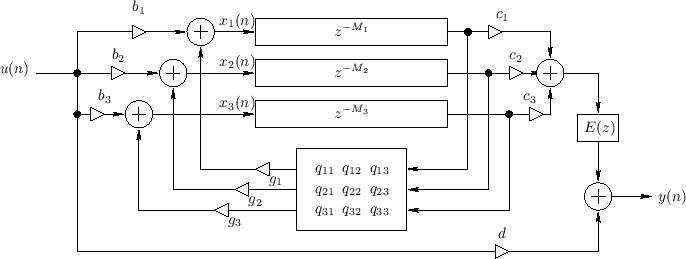

In [2241]:
ipd.Image(filename = "images/FDNScheme.png")

## Params

## Lossless Feedback Matrix

Hadamard Matrix

In [2242]:
# if((N & (N-1) == 0) and N != 0):
#     Had = 1/np.sqrt(N)*sp.linalg.hadamard(N)
#     print(Had)


Householder Matrix

In [2243]:
# u = np.ones(N)
# Hous = np.identity(N)-2/N*u*u.T
# print(Hous)

Once we have delayed the splitted signal, apply a filter (to each delay line). This filter is used to determine the $t_{60}$ of the reverb in each frequency band.

In [2244]:
def plotFilter(w, h, M_i):
        fig, ax1 = plt.subplots()
        ax1.set_title('Filter applied to delay line with M={}'.format(M_i))
        ax1.plot(w, 20 * np.log10(abs(h)), 'b')
        ax1.set_ylabel('Amplitude [dB]', color='b')
        ax1.set_xlabel('Frequency [rad/sample]')
        # ax2 = ax1.twinx()
        # angles = np.unwrap(np.angle(h))
        # ax2.plot(w, angles, 'g')
        # ax2.set_ylabel('Angle (radians)', color='g')
        # ax2.grid()
        # ax2.axis('tight')
        plt.show()

In [2245]:
# Case 3: Multiband filter design (preferred)
def multibandEqualizer(M_i, T, t60, freqs, fs):
    #for M_i in M:

        G_i = []
        # evaluate correct gains (one per band)
        for t60_f in t60:
            G_i.append(10**((-3*M_i)/(t60_f*fs))) 

        
        #print(G_i)

        taps = sp.signal.firwin2(numtaps=T, freq=freqs, gain=G_i, fs=fs)

        w, h = sp.signal.freqz(taps, fs=fs)

        # plotFilter(w, h, M_i)

        return taps

In [2246]:
# Case 1: Simple 1st order filter

def filter1st(M_i, t60, fs):
    R_M = []
    # R_M = 1-(6.91*M_i/t60*fs)
    for t60_f in t60:
        R_M.append(10**((-3*M_i)/(t60_f*fs))) 
            
    # pole
    p_i = (R_M[0]-R_M[-1])/(R_M[0]+R_M[-1])

    # gain
    g_i = 2*(R_M[0]*R_M[-1])/(R_M[0]+R_M[-1])   

    b = [0, g_i]
    a = [-p_i, 1]

    w, h = sp.signal.freqz(b,a, fs=fs)

    # plotFilter(w, h, M_i)

    return a, b


In [2247]:
# Case 2: Orthogonalized 1st order delay filter
def ortFilter1st(M_i, t60, fs):

        # gain
        g_i = 10**((-3*M_i)/(t60[0]*fs))

        # pole and zero
        p_i = np.log(10)/4 * np.log10(g_i) * (1-(1/(t60[-1]/t60[0])**2))

        print(g_i, p_i)

        b = [0, g_i*(1-p_i)]
        a = [-p_i, 1]

        w, h = sp.signal.freqz(b,a, fs=fs)

        # plotFilter(w, h, M_i)

        return a, b


Spectral coloration equalizer

In [2248]:
# coefficient of the filter:
def spectralEqualizer(t60, fs):
    b_coeff = (1-(t60[-1]/t60[0]))/(1+(t60[-1]/t60[0]))

    b = [1, -b_coeff]
    a = [1-b_coeff]

    return [a, b]

    # w, h = sp.signal.freqz(b,a, fs=fs)

    # fig, ax1 = plt.subplots()
    # ax1.set_title('Spectral Coloration Equalizer')
    # ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    # ax1.set_ylabel('Amplitude [dB]', color='b')
    # ax1.set_xlabel('Frequency [rad/sample]')
    # # ax2 = ax1.twinx()
    # # angles = np.unwrap(np.angle(h))
    # # ax2.plot(w, angles, 'g')
    # # ax2.set_ylabel('Angle (radians)', color='g')
    # # ax2.grid()
    # # ax2.axis('tight')
    # plt.show()

# Main:

In [2249]:
# test signal

fs = 22050
# signal = np.append(0.5*np.sin(2*np.pi*440*np.arange(0,0.1,1/fs)),np.zeros(15000)) #sp.signal.unit_impulse(22050)
signal = sp.signal.unit_impulse(50000)*0.9
# signal, _ = librosa.load('audio/voiced_a.wav', sr=fs, mono=True)

In [2250]:
# parameters


N = 8 # number of parallel delay lines

# weight coefficients (default to 1)
g = np.ones(N)
b = np.ones(N)
c = np.ones(N)

# reverberation time should be function of frequency, from 0 to fs/2
T=7 # filter taps
t60 = [3, 3, 2, 1, 0.8, 0.5, 0.1]
#t60 = [10, 0.1]
freqs = np.array([0, fs/(2*6), 2*fs/(2*6), 3*fs/(2*6), 4*fs/(2*6), 5*fs/(2*6), fs/2])
#freqs = np.array([0, fs/2])
print('Frequency bands {0} & relative reverberation times {1}'.format(freqs, t60)) 

# Delay lenghts
# TODO: create slider to select length (starting from min)
M_min = int(np.ceil(0.15*np.max(t60)*fs))

primeN = []

# generate some prime numbers...
for num in range(2,501):
    prime = True
    for i in range(2,num):
        if (num%i==0):
            prime = False
    if prime:
       primeN.append(num)

# compute M starting from (different) prime numbers
M = []
for i in primeN:
    m = np.floor(0.5+np.log(M_min)/np.log(i))
    if i**m>M_min:
        M.append(int(i**m))

M = np.sort(M)

M = M[:N]

print('Selected delay lengths:',M)
# TODO: select numbers according to min desired length


Frequency bands [    0.   1837.5  3675.   5512.5  7350.   9187.5 11025. ] & relative reverberation times [3, 3, 2, 1, 0.8, 0.5, 0.1]
Selected delay lengths: [10201 10609 11449 11881 12167 12769 14641 15625]


In [2251]:
# feedback matrices

# hadamard
if((N & (N-1) == 0) and N != 0):
    Had = 1/np.sqrt(N)*sp.linalg.hadamard(N)
else:
    Had = np.zeros((N, N))

#householder
u = np.ones(N)
Hous = np.identity(N)-2/N*u*u.T



In [2252]:
sig = np.append(signal, np.zeros(2*np.max(M)))

output = np.zeros(sig.size)

B = np.ones(N)
C = np.ones(N)
G = np.repeat(0.5,N)
d = 1

bufferSize = np.max(M) + T



# filter design
taps = np.zeros((N,T))

for i in range(N):
    taps[i] = multibandEqualizer(M[i], T, t60, freqs, fs)



y = np.zeros(N).T
mix = np.zeros(N).T
filtered = np.zeros(N).T
oldFiltered = np.zeros(N).T
x = np.zeros(N).T
out = np.zeros((N,np.max(M)+sig.size))

writeIndex = copy.deepcopy(M)
readIndex = np.zeros(N, dtype=int).T
# print(writeIndex, readIndex)

filterIndex = copy.deepcopy(readIndex)
buffer = np.zeros((N, bufferSize))
j = 0

for sample in sig:

    for i in range(N): # do it for every delay line (in //)

        # read the samples from the buffers
        y[i] = buffer[i][readIndex[i]]

        # extract output
        out[i][j] = C[i]*buffer[i][readIndex[i]]
        
        # now mix up signals by applying feedback matrix (Q)
        # ! check this y
        mix[i] = np.sum(y*Had[i])

        # ! check errors here
        # filter the signals (g)
   
        # multiband FIR: y(n) = h_0*x(n) + h_1*x(n-1) + h_2*x(n-2) + ...
        filterIndex[i] = readIndex[i] # set current sample in the buffer
        # current sample multiplied by first tap h_0
        filtered[i] = mix[i]*taps[i][0]
        for tap in taps[i][1:]:
            filterIndex[i] = filterIndex[i] -1 # select previous sample index
            if filterIndex[i]<0: # if we reach the first in the buffer, wrap to the end
                filterIndex[i] = bufferSize-1
                
            filtered[i] = filtered[i] + buffer[i][filterIndex[i]]*tap # cumulative sum of (samples (going backwards) * relative tap)

        # new signal to be processed (input+feedback)
        x[i] = B[i]*sample + filtered[i]*G[i]

        # update buffer by writing new sample in correct position (delay)
        buffer[i][writeIndex[i]] = x[i]

        # check if indices of the circular buffer are ok
        readIndex[i] += 1
        writeIndex[i] += 1
        if readIndex[i]>=bufferSize:
            readIndex[i] = 0
            

        if writeIndex[i]>=bufferSize:
            writeIndex[i] = 0

    j = j+1



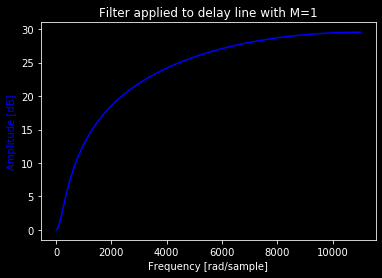

In [2253]:
# tone equalization filter

a, b = spectralEqualizer(t60, fs)
w, h = sp.signal.freqz(b,a, fs=fs)
plotFilter(w, h, 1)

# output = np.sum(out, axis= 0) 
output = sp.signal.lfilter(b, a, np.sum(out, axis= 0))
# print(np.sum(out[:][:], axis= 0))


# final result
sig = np.append(signal, np.zeros(output.size-signal.size))
output = output + sig*d


[10201 10609 11449 11881 12167 12769 14641 15625]


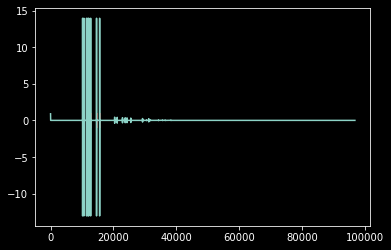

In [2254]:
#plt.plot(sig)
time = np.arange(0, len(output)) / fs
plt.vlines(np.array(M), -1, 1, colors='r')
plt.plot(output) # [:np.max(M)+2]
print(M)

ipd.display(ipd.Audio(output, rate=fs))

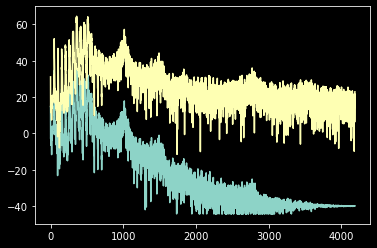

In [2255]:
# prova
#whiteN = np.random.normal(0, 0.005, size= 100000)
whiteN, _ = librosa.load('audio/voiced_a.wav', sr=fs, mono=True)

#plt.plot(librosa.amplitude_to_db(np.abs(np.fft.fft(whiteN))[:len(whiteN)//2]))

filtered = sp.signal.lfilter(taps[-1], 1, whiteN)
filtered2 = sp.signal.lfilter(b, a, whiteN)
plt.plot(librosa.amplitude_to_db(np.abs(np.fft.fft(filtered))[:len(whiteN)//2]))
plt.plot(librosa.amplitude_to_db(np.abs(np.fft.fft(filtered2))[:len(whiteN)//2]))